<img src='ted_logo.png' style="width:300px">

## Predicting views of TED Talk

Dataset on CC license aquired from Kaggle: https://www.kaggle.com/rounakbanik/ted-talks

In [560]:
from datetime import datetime, date
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

## 1. Loading Dataset and simple analysis to understand it

In [561]:
ted_path = r'C:\Users\Jędrzej\OneDrive\Pulpit\Zbiorczy\data analysis Udacity\TedTalksProject\ted_main.csv'
ted = pd.read_csv(ted_path)
ted.head(3)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292


In [562]:
ted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
comments              2550 non-null int64
description           2550 non-null object
duration              2550 non-null int64
event                 2550 non-null object
film_date             2550 non-null int64
languages             2550 non-null int64
main_speaker          2550 non-null object
name                  2550 non-null object
num_speaker           2550 non-null int64
published_date        2550 non-null int64
ratings               2550 non-null object
related_talks         2550 non-null object
speaker_occupation    2544 non-null object
tags                  2550 non-null object
title                 2550 non-null object
url                   2550 non-null object
views                 2550 non-null int64
dtypes: int64(7), object(10)
memory usage: 338.8+ KB


In [563]:
ted.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views'],
      dtype='object')

### Transforming date columns

In [564]:
def date_to_weekday(column): #from date take weekday
    new_column=[]
    for row in column:
        weekday = row.split('-')
        weekday = date(int(weekday[0]), int(weekday[1]), int(weekday[2])).isoweekday()
        new_column.append(weekday)
    return pd.Series(new_column)

#### Film_date transformation from UNIX to human-readable format

In [565]:
ted['film_year'] = ted.film_date.apply(lambda x: int(datetime.utcfromtimestamp(x).strftime('%Y')))
ted['film_month'] = ted.film_date.apply(lambda x: int(datetime.utcfromtimestamp(x).strftime('%m')))
ted['film_day'] = ted.film_date.apply(lambda x: int(datetime.utcfromtimestamp(x).strftime('%d')))
ted['film_weekday'] = date_to_weekday(ted.film_date.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')))

In [566]:
ted.film_date = ted.film_date.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d, %H:%M:%S'))
ted.film_date.value_counts().head()

2017-04-24, 00:00:00    64
2007-03-03, 00:00:00    54
2009-02-06, 00:00:00    31
2009-02-05, 00:00:00    30
2011-03-02, 00:00:00    30
Name: film_date, dtype: int64

#### Published_date transformation from UNIX to human-readable format

In [567]:
ted['published_year'] = ted.published_date.apply(lambda x: int(datetime.utcfromtimestamp(x).strftime('%Y')))
ted['published_month'] = ted.published_date.apply(lambda x: int(datetime.utcfromtimestamp(x).strftime('%m')))
ted['published_day'] = ted.published_date.apply(lambda x: int(datetime.utcfromtimestamp(x).strftime('%d')))
ted['published_weekday'] = date_to_weekday(ted.published_date.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')))

In [568]:
ted.published_date = ted.published_date.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d,%H:%M:%S'))
ted.published_date.value_counts().head() #not every time is 00:00:00, we will not drop that

2007-04-05,00:11:00    20
2006-06-27,00:11:00     4
2006-07-25,00:11:00     3
2006-12-14,00:11:00     3
2006-10-31,00:11:00     3
Name: published_date, dtype: int64

In [569]:
ted['published_hour'] = ted.published_date.apply(lambda x: int(x.split(',')[1][:2]))

In [570]:
ted = ted.drop(columns=['published_date', 'film_date']) #drop transformed columns

#### Transform duration from seconds to minutes

In [571]:
ted.duration = ted.duration.apply(lambda x: int(x/60))

#### Views will be displayed in thousands 

In [572]:
ted.views = ted.views.apply(lambda x: x/1000)

In [573]:
ted.columns

Index(['comments', 'description', 'duration', 'event', 'languages',
       'main_speaker', 'name', 'num_speaker', 'ratings', 'related_talks',
       'speaker_occupation', 'tags', 'title', 'url', 'views', 'film_year',
       'film_month', 'film_day', 'film_weekday', 'published_year',
       'published_month', 'published_day', 'published_weekday',
       'published_hour'],
      dtype='object')

In [574]:
ted = ted[['main_speaker', 'num_speaker','speaker_occupation', 'title', 'name', 'description', 'event', 'duration', 'tags','languages','comments','related_talks', 'ratings', 'url', 'film_year','film_month','film_day','film_weekday', 'published_year','published_month','published_day','published_hour','published_weekday', 'views']]
# setting different order of columns

In [575]:
ted.describe() #describing numerical columns

,num_speaker,duration,languages,comments,film_year,film_month,film_day,film_weekday,published_year,published_month,published_day,published_hour,published_weekday,views
count,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000
mean,1.028235,13.277255,27.326275,191.562353,2011.466275,5.660784,14.425882,3.718431,2012.093333,6.301569,15.421961,11.929412,3.152941,1698.297482
std,0.207705,6.230784,9.563452,282.315223,3.727823,3.397757,8.933113,1.670579,3.011667,3.367925,8.644089,5.541643,1.542691,2498.479372
min,1.000000,2.000000,0.000000,2.000000,1972.000000,1.000000,1.000000,1.000000,2006.000000,1.000000,1.000000,0.000000,1.000000,50.443000
25%,1.000000,9.000000,23.000000,63.000000,2009.000000,3.000000,6.000000,3.000000,2010.000000,3.000000,8.000000,9.000000,2.000000,755.792750
50%,1.000000,14.000000,28.000000,118.000000,2012.000000,5.000000,14.000000,4.000000,2012.000000,6.000000,15.000000,15.000000,3.000000,1124.523500
75%,1.000000,17.000000,33.000000,221.750000,2014.000000,9.000000,23.000000,5.000000,2015.000000,9.000000,23.000000,15.000000,4.000000,1700.759500
max,5.000000,87.000000,72.000000,6404.000000,2017.000000,12.000000,31.000000,7.000000,2017.000000,12.000000,31.000000,23.000000,7.000000,47227.110000


## 2. Plotting correlation between selected numeric features

In [576]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] #numeric values
ted_numerics = ted.select_dtypes(include=numerics)
print(ted_numerics.shape) 
ted_numerics.head()

(2550, 14)


,num_speaker,duration,languages,comments,film_year,film_month,film_day,film_weekday,published_year,published_month,published_day,published_hour,published_weekday,views
0,1,19,60,4553,2006,2,25,6,2006,6,27,0,2,47227.110
1,1,16,43,265,2006,2,25,6,2006,6,27,0,2,3200.520
2,1,21,26,124,2006,2,24,5,2006,6,27,0,2,1636.292
3,1,18,35,200,2006,2,26,7,2006,6,27,0,2,1697.550
4,1,19,48,593,2006,2,22,3,2006,6,27,20,2,12005.869


### 2.1 Data distribution

Text(0.5, 1.0, 'Impact of comments on views')

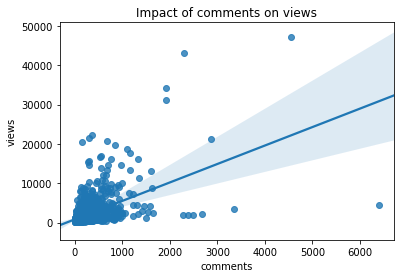

In [577]:
sns.regplot(data=ted, x='comments', y='views')
plt.title("Impact of comments on views")

Text(0, 0.5, 'views (in thousands)')

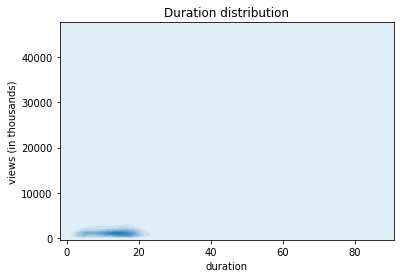

In [578]:
sns.kdeplot(data=ted.duration, data2=ted.views, shade=True)
plt.title('Duration distribution')
plt.ylabel("views (in thousands)")

Text(0, 0.5, 'views (in thousands)')

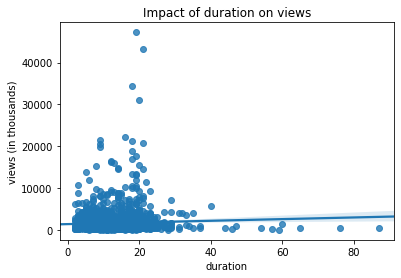

In [579]:
sns.regplot(data=ted, x='duration', y='views')
plt.title("Impact of duration on views")
plt.ylabel('views (in thousands)')

Text(0, 0.5, 'views (in thousands)')

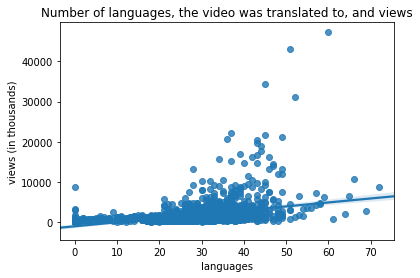

In [580]:
sns.regplot(data=ted, x='languages', y='views')
plt.title('Number of languages, the video was translated to, and views')
plt.ylabel('views (in thousands)')

Text(0, 0.5, 'views (in thousands)')

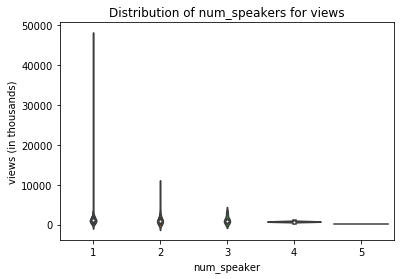

In [581]:
sns.violinplot(data=ted, x='num_speaker', y='views')
plt.title('Distribution of num_speakers for views')
plt.ylabel('views (in thousands)')

Text(0.5, 1.0, 'Distribution of films for each month by production and publication day')

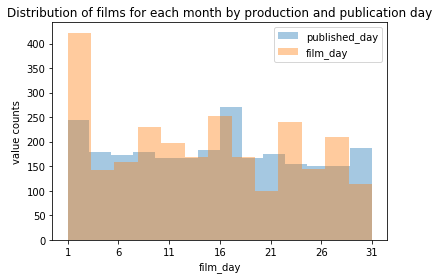

In [582]:
sns.distplot(ted.published_day, kde=False, label='published_day')
sns.distplot(ted.film_day, kde=False, label='film_day')
plt.xticks(np.arange(1,32, step=5))
plt.legend()
plt.ylabel('value counts')
plt.title('Distribution of films for each month by production and publication day')

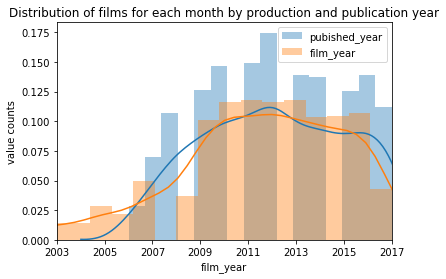

In [583]:
sns.distplot(ted.published_year, label='pubished_year')
sns.distplot(ted.film_year, label='film_year')
plt.xlim(left=2003, right=2017)
plt.xticks(np.arange(2003, 2018, step=2))
plt.ylabel('value counts')
plt.title('Distribution of films for each month by production and publication year')
plt.legend()

Text(0.5, 1.0, 'Distribution of films for each month by production and publication month')

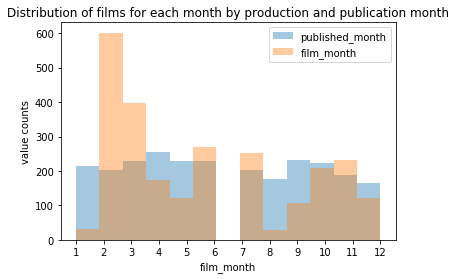

In [584]:
sns.distplot(ted.published_month, kde=False, label='published_month')
sns.distplot(ted.film_month, kde=False, label='film_month')
plt.xticks(np.arange(1,13, step=1))
plt.legend()
plt.ylabel('value counts')
plt.title('Distribution of films for each month by production and publication month')

Text(0.5, 1.0, 'Data distribution over years of publication and production')

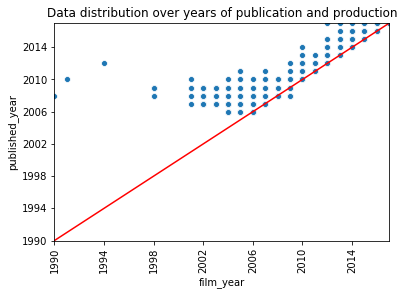

In [585]:
x=np.linspace(1990, 2017, 100)
y=x
sns.scatterplot(data=ted, x='film_year', y='published_year')
plt.plot(x, y, c='red')
plt.xlim(left=1990, right=2017)
plt.ylim(bottom=1990, top=2017)
plt.xticks(np.arange(1990, 2018, step=4), rotation='vertical')
plt.yticks(np.arange(1990, 2018, step=4))
plt.title('Data distribution over years of publication and production')

Text(0.5, 1.0, 'Median of views for each month of production and publication ')

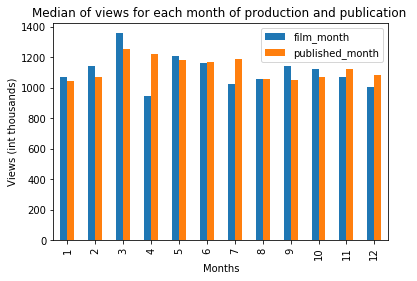

In [586]:
y1=ted.groupby(by='film_month').views.median()
y2=ted.groupby(by='published_month').views.median()

by_month = pd.concat([y1,y2], axis=1)
by_month.columns=['film_month', 'published_month']
by_month.plot(kind='bar')
plt.xlabel('Months')
plt.ylabel('Views (int thousands)')
plt.title('Median of views for each month of production and publication ')

Text(0.5, 1.0, 'Median of views for each publication day')

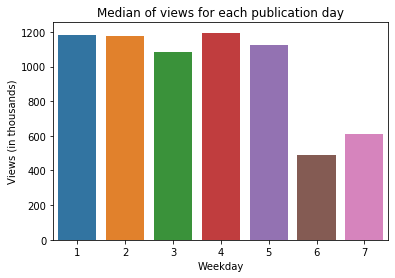

In [587]:
sns.barplot(x=ted.published_weekday.unique(), y=ted.groupby(by='published_weekday').views.median())
plt.xlabel('Weekday')
plt.ylabel('Views (in thousands)')
plt.title('Median of views for each publication day')

Text(0.5, 1.0, 'Median of views for each production day')

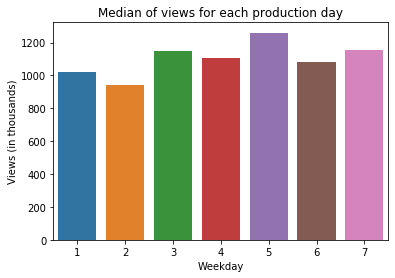

In [588]:
sns.barplot(x=ted.film_weekday.unique(), y=ted.groupby(by='film_weekday').views.median())
plt.xlabel('Weekday')
plt.ylabel('Views (in thousands)')
plt.title('Median of views for each production day')

Text(0, 0.5, 'Views (in thousands)')

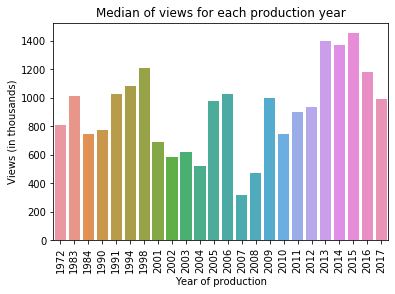

In [589]:
sns.barplot(x=ted.film_year.unique(), y=ted.groupby(by='film_year').views.median())
plt.xticks(rotation='vertical')
plt.title('Median of views for each production year')
plt.xlabel('Year of production')
plt.ylabel('Views (in thousands)')

Text(0, 0.5, 'Views (in thousands)')

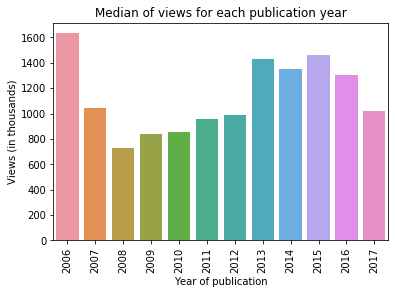

In [590]:
sns.barplot(x=ted.published_year.unique(), y=ted.groupby(by='published_year').views.median())
plt.xticks(rotation='vertical')
plt.title('Median of views for each publication year')
plt.xlabel('Year of publication')
plt.ylabel('Views (in thousands)')

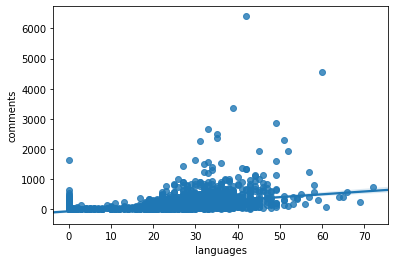

In [591]:
sns.regplot(data=ted, x='languages', y='comments')

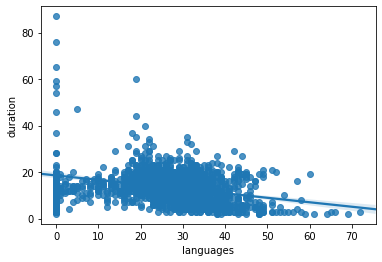

In [592]:
sns.regplot(data=ted, x='languages', y='duration')

## Data pre-processing

In [593]:
ted_copy = ted.copy() #creating a copy of dataset
label_encoder = LabelEncoder() #generating label encoder for categorical data

In [594]:
ted_copy.columns

Index(['main_speaker', 'num_speaker', 'speaker_occupation', 'title', 'name',
       'description', 'event', 'duration', 'tags', 'languages', 'comments',
       'related_talks', 'ratings', 'url', 'film_year', 'film_month',
       'film_day', 'film_weekday', 'published_year', 'published_month',
       'published_day', 'published_hour', 'published_weekday', 'views'],
      dtype='object')

#### Comments feature

In [595]:
#ted_copy = ted_copy.drop(columns='comments')

We would be dropping comments if we were to predict views of newly released Ted-talk. 

#### Description feature

It is difficult to interpret the information contained in description. We can create length of the description and show the impact of length on views

In [596]:
ted_copy.description.tail() #simple text, describing content of the video

2545    Between 2008 and 2016, the United States depor...
2546    How can you study Mars without a spaceship? He...
2547    Science fiction visions of the future show us ...
2548    In an unmissable talk about race and politics ...
2549    With more than half of the world population li...
Name: description, dtype: object

In [597]:
ted_copy.description = ted_copy.description.apply(lambda x: len(x)) #changing description to len(description)

In [598]:
ted_copy[['description']] = MinMaxScaler().fit_transform(ted_copy[['description']])

Text(0, 0.5, 'views (in thousands)')

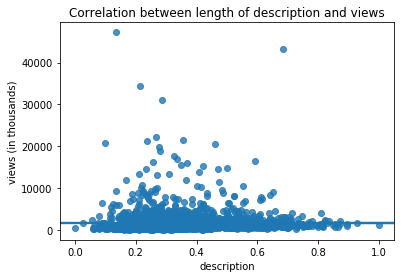

In [599]:
sns.regplot(data=ted_copy, x='description', y='views')
plt.title('Correlation between length of description and views')
plt.ylabel('views (in thousands)')

#### Duration

In [600]:
ted_copy[['duration']] = MinMaxScaler().fit_transform(ted_copy[['duration']])

#### Event

In [601]:
ted_copy.event.value_counts().tail()

Elizabeth G. Anderson School    1
TEDxVictoria                    1
TEDxAmazonia                    1
TEDxEQChCh                      1
TED@Nairobi                     1
Name: event, dtype: int64

In [602]:
list(ted_copy.event.unique())[:3]

['TED2006', 'TED2004', 'TED2005']

We will divide values to 3 categories - TED, TEDx, Others

In [603]:
def event_rename(column):
    new_column = []
    for index, content in enumerate(column):
        one_name = ''.join(content.split(' '))
        if one_name[3] in ['1','2'] and one_name.startswith('TED'):
            new_column.append('TED')
        elif one_name.startswith('TEDGlobal') or one_name.startswith('TEDWomen'):
            new_column.append('TED')
        elif one_name.startswith('TED'):
            new_column.append('TEDx')
        else:
            new_column.append('Other')
    return pd.Series(new_column)
ted_copy['event_renamed'] = event_rename(ted_copy.event)

In [604]:
ted_copy.loc[:,['event', 'event_renamed']].head()

,event,event_renamed
0,TED2006,TED
1,TED2006,TED
2,TED2006,TED
3,TED2006,TED
4,TED2006,TED


In [605]:
ted_copy = ted_copy.drop(columns='event')

#### Comments

In [606]:
ted_copy[['comments']] = MinMaxScaler().fit_transform(ted_copy[['comments']])

#### Languages

In [607]:
ted_copy[['languages']] = MinMaxScaler().fit_transform(ted_copy[['languages']])

#### Main_speaker

In [608]:
ted_copy.loc[ted_copy.num_speaker>=3] #displaying rows with 3 speakers and more to understand the format

,main_speaker,num_speaker,speaker_occupation,title,name,description,duration,tags,languages,comments,...,film_month,film_day,film_weekday,published_year,published_month,published_day,published_hour,published_weekday,views,event_renamed
796,"David Byrne, Ethel + Thomas Dolby",3,Electronic music pioneer,"""(Nothing But) Flowers"" with string quartet","David Byrne, Ethel + Thomas Dolby: ""(Nothing B...",0.158996,0.011765,"['future', 'garden', 'music', 'performance', '...",0.472222,0.009528,...,2,12,5,2010,10,22,8,5,621.361,TED
1107,"Lauren Hodge, Shree Bose + Naomi Shah",3,Science fair winner,Award-winning teenage science in action,"Lauren Hodge, Shree Bose + Naomi Shah: Award-w...",0.210600,0.164706,"['TEDx', 'cancer', 'chemistry', 'code', 'food'...",0.347222,0.026242,...,12,8,4,2012,1,10,16,2,913.084,TEDx
1543,"Diana Reiss, Peter Gabriel, Neil Gershenfeld a...",4,Cognitive psychologist,The interspecies internet? An idea in progress,The interspecies internet? An idea in progress,0.437936,0.211765,"['Internet', 'animals', 'technology']",0.277778,0.019994,...,2,28,4,2013,7,10,15,3,717.979,TED
1971,Bill T. Jones,3,"Director/choreographer, dancer","The dancer, the singer, the cellist ... and a ...","Bill T. Jones: The dancer, the singer, the cel...",0.476987,0.047059,"['TED Fellows', 'dance', 'entertainment', 'liv...",0.527778,0.015308,...,3,18,3,2015,5,6,15,3,1257.079,TED
2215,Adam Driver,3,Actor and Marine Corps veteran,My journey from Marine to actor,Adam Driver: My journey from Marine to actor,0.686192,0.188235,"['collaboration', 'communication', 'entertainm...",0.333333,0.005311,...,11,3,2,2016,5,27,15,5,3016.666,TEDx
2319,"Amanda Palmer, Jherek Bischoff, Usman Riaz",3,"Musician, blogger","""Space Oddity""","Amanda Palmer, Jherek Bischoff, Usman Riaz: ""S...",0.271967,0.047059,"['TED Fellows', 'guitar', 'live music', 'music...",0.388889,0.000937,...,2,19,5,2016,11,4,12,5,738.590,TED
2334,"Alicia Garza, Patrisse Cullors and Opal Tometi",4,"Writer, activist",An interview with the founders of Black Lives ...,"Alicia Garza, Patrisse Cullors and Opal Tometi...",0.610879,0.164706,"['Africa', 'Gender equality', 'activism', 'col...",0.180556,0.015152,...,10,27,4,2016,11,29,15,2,782.276,TED
2421,"Gretchen Carlson, David Brooks",4,"TV journalist, women's empowerment advocate",Political common ground in a polarized United ...,"Gretchen Carlson, David Brooks: Political comm...",0.456067,0.529412,"['United States', 'collaboration', 'communicat...",0.069444,0.006248,...,3,1,3,2017,4,3,21,1,890.478,TEDx
2507,Jon Boogz and Lil Buck,5,Movement artist,A dance to honor Mother Earth,Jon Boogz and Lil Buck: A dance to honor Mothe...,0.207810,0.082353,"['art', 'creativity', 'dance', 'performance', ...",0.166667,0.000625,...,4,24,1,2017,8,11,10,5,182.975,TED


In [609]:
ted_copy.main_speaker.loc[ted_copy.num_speaker==0] #looking for videos with no speakers

Series([], Name: main_speaker, dtype: object)

In [610]:
def speakers(column): # extracting surnames from datapoint
    new_column=[]
    for content in column:
        surnames=content.split(' ')
        new_surnames = []
        for ind,word in enumerate(surnames):
            if len(word)>0 and word[-1]==',':
                new_surnames.append(word.strip(','))
                
            if word=='and' or word=='+':
                new_surnames.append(surnames[ind-1])
                
            if ind==len(surnames)-1:
                new_surnames.append(word)
        new_column.append(new_surnames)
    return new_column

In [611]:
ted_copy['speaker'] = speakers(ted_copy.main_speaker)

In [612]:
ted_copy = ted_copy.drop(columns='main_speaker')

#### Name

Name column provides no information gain. Column contains only speakers and title - we have that in other columns

In [613]:
ted_copy = ted_copy.drop(columns='name') 

#### Speaker_occupation

In [614]:
ted_copy.loc[ted_copy.speaker_occupation.isnull()==True] #occupation is NaN

,num_speaker,speaker_occupation,title,description,duration,tags,languages,comments,related_talks,ratings,...,film_day,film_weekday,published_year,published_month,published_day,published_hour,published_weekday,views,event_renamed,speaker
1113,1,NaN,Meet the Water Canary,0.351464,0.011765,"['TED Fellows', 'design', 'global development'...",0.527778,0.022337,"[{'id': 523, 'hero': 'https://pe.tedcdn.com/im...","[{'id': 10, 'name': 'Inspiring', 'count': 73},...",...,14,4,2012,1,16,16,1,353.749,TED,[Luthra]
1192,1,NaN,I am a pirate,0.284519,0.188235,"['Internet', 'TEDx', 'global issues', 'politic...",0.138889,0.018744,"[{'id': 1329, 'hero': 'https://pe.tedcdn.com/i...","[{'id': 8, 'name': 'Informative', 'count': 156...",...,11,7,2012,4,1,14,7,181.010,TEDx,[Falkvinge]
1220,1,NaN,Tracking our online trackers,0.478382,0.047059,"['Internet', 'advertising', 'business', 'priva...",0.444444,0.039831,"[{'id': 1370, 'hero': 'https://pe.tedcdn.com/i...","[{'id': 23, 'name': 'Jaw-dropping', 'count': 9...",...,29,3,2012,5,3,15,4,2098.639,TED,[Kovacs]
1656,1,NaN,To hear this music you have to be there. Liter...,0.305439,0.047059,"['TED Fellows', 'entertainment', 'music', 'tec...",0.458333,0.021556,"[{'id': 1152, 'hero': 'https://pe.tedcdn.com/i...","[{'id': 1, 'name': 'Beautiful', 'count': 211},...",...,30,3,2014,1,10,16,5,1284.510,TEDx,[Holladay]
1911,1,NaN,Old books reborn as art,0.225941,0.047059,"['TEDYouth', 'art', 'books', 'creativity']",0.472222,0.007185,"[{'id': 610, 'hero': 'https://pe.tedcdn.com/im...","[{'id': 1, 'name': 'Beautiful', 'count': 361},...",...,4,2,2015,2,6,16,5,1159.937,TEDx,[Dettmer]
1949,1,NaN,The day I stood up alone,0.516039,0.058824,"['TED Fellows', 'activism', 'art', 'corruption...",0.458333,0.010622,"[{'id': 1757, 'hero': 'https://pe.tedcdn.com/i...","[{'id': 3, 'name': 'Courageous', 'count': 614}...",...,20,1,2015,4,2,15,4,1342.431,TED,[Mwangi]


In [615]:
ted_copy.speaker_occupation.value_counts().head()

Writer          45
Designer        34
Artist          34
Journalist      33
Entrepreneur    31
Name: speaker_occupation, dtype: int64

In [616]:
def get_occupation(column): #extracting only first word of occupation
    new_column=[]
    for row in column:
        if pd.isnull(row):
            new_column.append('speaker')
        else:
            line = str(row.split(' ')[0])
            line = str(line.split('/')[0])
            line = line.strip(',').strip(';').lower()
            new_column.append(line)
            
    return pd.Series(new_column)

In [617]:
ted_copy['occupation'] = get_occupation(ted_copy.speaker_occupation) 
ted_copy = ted_copy.drop(columns='speaker_occupation') #drop orignial occupation

In [618]:
jobs = set(ted_copy.occupation.value_counts().head().index) #most popular occupations
ted_copy.occupation = ted_copy.occupation.apply(lambda x: x if x in jobs else 'other') 
ted_copy['occupation'] = label_encoder.fit_transform(ted_copy['occupation']) #label encoder for the most popular occupations

#### URL

URL provides no information gain

In [619]:
ted_copy = ted_copy.drop(columns='url')

#### Title

It is hard to easly extract and use information provided by title column

In [620]:
ted_copy = ted_copy.drop(columns='title')

#### Tags

In [621]:
ted_copy.tags.tail()

2545    ['TED Residency', 'United States', 'community'...
2546    ['Mars', 'South America', 'TED Fellows', 'astr...
2547    ['AI', 'ants', 'fish', 'future', 'innovation',...
2548    ['Internet', 'TEDx', 'United States', 'communi...
2549    ['cities', 'design', 'future', 'infrastructure...
Name: tags, dtype: object

In [622]:
def get_tags(column): # extract first 2 tags as they are the closest to what the film is about, ommit TED if it a tag
    new_column1=[]
    new_column2=[]
    for row in column:
        line = row.strip('][').split(', ') 
        line = list(map(lambda x: x.strip("'"), line))
        how_many=0
        while how_many<2 and how_many<len(line):
            if len(line[how_many])>=3:
                if line[how_many][:3]=="TED":
                    line.pop(how_many)   
                else:
                    how_many+=1
            else:
                how_many+=1
        new_column1.append(line[0])
        if len(line)>1:
            new_column2.append(line[1])
        else:
            new_column2.append(line[0])
    return pd.Series(new_column1), pd.Series(new_column2)
        

In [623]:
ted_copy['tag1'], ted_copy['tag2'] = get_tags(ted_copy.tags) #creating 2 new columns with tags
ted_copy = ted_copy.drop(columns='tags') #drop original tags column

In [624]:
tag1 = list(ted_copy.tag1.value_counts().head(5).index) #5 most popular from tag1
tag2 = list(ted_copy.tag2.value_counts().head(5).index)# 5 most popular from tag2
tags = set(tag1+tag2) #set of the most popular tags

In [625]:
ted_copy.tag1 = ted_copy.tag1.apply(lambda x: x if x in tags else 'other') #saving only the most popular tags
ted_copy.tag2 = ted_copy.tag2.apply(lambda x: x if x in tags else 'other') 

ted_copy['tag1'] = label_encoder.fit_transform(ted_copy['tag1']) #label encoder for remaining tags
ted_copy['tag2'] = label_encoder.fit_transform(ted_copy['tag2'])

#### Related_talks and ratings

In [626]:
ted_copy = ted_copy.drop(columns=['related_talks', 'ratings'])

In [627]:
ted_copy.head()

,num_speaker,description,duration,languages,comments,film_year,film_month,film_day,film_weekday,published_year,published_month,published_day,published_hour,published_weekday,views,event_renamed,speaker,occupation,tag1,tag2
0,1,0.135286,0.200000,0.833333,0.710872,2006,2,25,6,2006,6,27,0,2,47227.110,TED,[Robinson],1,8,8
1,1,0.252441,0.164706,0.597222,0.041081,2006,2,25,6,2006,6,27,0,2,3200.520,TED,[Gore],4,8,8
2,1,0.209205,0.223529,0.361111,0.019057,2006,2,24,5,2006,6,27,0,2,1636.292,TED,[Pogue],4,8,6
3,1,0.224547,0.188235,0.486111,0.030928,2006,2,26,7,2006,6,27,0,2,1697.550,TED,[Carter],4,8,1
4,1,0.167364,0.200000,0.666667,0.092315,2006,2,22,3,2006,6,27,20,2,12005.869,TED,[Rosling],4,0,8


## Building model

In [628]:
X = ted_copy.copy()

In [629]:
def dummy_generator(df, features):
    for x in features:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x,1)
        df = pd.concat([df,dummies], axis=1)
    return df

In [630]:
def outlier_detection(column):
    outliers=[]
    threshold=10 
    mean = np.mean(column)
    std = np.std(column)
    
    for index,row in enumerate(column):
        z_score = (row-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(index)
    return outliers

In [631]:
def mape(y_true, y_pred): #mean absolute percentage error
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [632]:
outliers = outlier_detection(X.views) # outlier selection
X = X.drop(outliers) #drop outliers
X.shape

(2546, 20)

In [633]:
X = dummy_generator(X, ['event_renamed'])

### Feature selection

In [634]:
Y = X['views']
X = X.drop(columns=['speaker','views'])

extra_trees_model = ExtraTreesRegressor(n_estimators=10) # Extra Trees Regressor can help us select the most important features
extra_trees_model.fit(X, Y)

a = list(extra_trees_model.feature_importances_)
b = list(X.columns)

for i in zip(a,b):
    print(i)

(0.0018949282973695295, 'num_speaker')
(0.04114363128102885, 'description')
(0.04520739198319866, 'duration')
(0.2249856843968117, 'languages')
(0.23048842750213075, 'comments')
(0.03946826439004095, 'film_year')
(0.01954995077398328, 'film_month')
(0.039336163677499744, 'film_day')
(0.03738070082541046, 'film_weekday')
(0.07433887485692788, 'published_year')
(0.028368585518912116, 'published_month')
(0.032935935861093626, 'published_day')
(0.05025210474190054, 'published_hour')
(0.03049772437325803, 'published_weekday')
(0.02905841580440848, 'occupation')
(0.018165570951020834, 'tag1')
(0.036661512377540825, 'tag2')
(0.0014101483656577406, 'event_renamed_Other')
(0.005745965677126117, 'event_renamed_TED')
(0.013110018344679935, 'event_renamed_TEDx')


In [635]:
selector = RFE(RandomForestRegressor(n_estimators=10), 5)
selector = selector.fit(X, Y)

features = []
for status,feature in zip(list(selector.support_),list(X.columns)):
    print(status,feature)
    if status==True:
        features.append(feature)
print(features)

False num_speaker
True description
False duration
True languages
True comments
False film_year
False film_month
True film_day
False film_weekday
True published_year
False published_month
False published_day
False published_hour
False published_weekday
False occupation
False tag1
False tag2
False event_renamed_Other
False event_renamed_TED
False event_renamed_TEDx
['description', 'languages', 'comments', 'film_day', 'published_year']


In [636]:
X_train, X_test, y_train, y_test = train_test_split(X[features], Y) 

#### Dummy Regressor

In [637]:
dummy_regressor = DummyRegressor(strategy='median')
dummy_regressor.fit(X_train, y_train)
dummy_regressor_predictions = dummy_regressor.predict(X_test)

In [638]:
print(mean_absolute_error(y_test, dummy_regressor_predictions)) 
print(np.sqrt(mean_squared_error(y_test, dummy_regressor_predictions)))
print(round(r2_score(y_test, dummy_regressor_predictions), ndigits=5))

853.094387755102
1896.1777023797447
-0.06884


#### Random Forest Regressor

In [639]:
params = dict(n_estimators = list(np.arange(40,101, step=10)), max_leaf_nodes = list(np.arange(45, 101, step=20)))

grid1 = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring='neg_mean_absolute_error', return_train_score=False )
grid1.fit(X_train, y_train)
print('done')

done


In [640]:
grid_scores_df1 = pd.DataFrame(grid1.cv_results_)[['param_max_leaf_nodes','param_n_estimators','mean_test_score','rank_test_score']]
grid_scores_df1.sort_values(by='rank_test_score').head()

,param_max_leaf_nodes,param_n_estimators,mean_test_score,rank_test_score
14,85,40,-717.387036,1
18,85,80,-718.042934,2
15,85,50,-718.800992,3
19,85,90,-718.810968,4
7,65,40,-718.910295,5


#### K Neighbors Regressor

In [641]:
params = dict(n_neighbors = list(np.arange(10,140, step=6)))

grid2 = GridSearchCV(KNeighborsRegressor(), params, cv=10, scoring='neg_mean_absolute_error', return_train_score=False )
grid2.fit(X_train, y_train)
print('done')

done


In [642]:
grid_scores_df2 = pd.DataFrame(grid2.cv_results_)[['param_n_neighbors', 'mean_test_score', 'rank_test_score']]
grid_scores_df2.sort_values(by='rank_test_score').head()

,param_n_neighbors,mean_test_score,rank_test_score
1,16,-987.900647,1
0,10,-989.763645,2
2,22,-1005.554552,3
4,34,-1019.729680,4
3,28,-1021.088972,5


### Best model

In [643]:
X_train.columns

Index(['description', 'languages', 'comments', 'film_day', 'published_year'], dtype='object')

In [644]:
best_model = RandomForestRegressor(n_estimators=grid_scores_df1.param_n_estimators.loc[grid_scores_df1.rank_test_score==1].values[0], max_leaf_nodes=grid_scores_df1.param_max_leaf_nodes.loc[grid_scores_df1.rank_test_score==1].values[0])
best_model.fit(X_train, y_train)
best_model_prediciton = best_model.predict(X_test)

In [645]:
print('Predictions of best model on test dataset:')
print('MAE', mean_absolute_error(y_test, best_model_prediciton))
print('MSE', math.sqrt(mean_squared_error(y_test, best_model_prediciton)))
print('R^2', round(r2_score(y_test, best_model_prediciton), ndigits=5))
print('MAPE', int(mape(y_test, best_model_prediciton)), '%') 

Predictions of best model on test dataset:
MAE 698.6893620874167
MSE 1532.0035324828757
R^2 0.30229
MAPE 47 %
